# Importing Libraries and unziping data

In [108]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [79]:
!unzip /content/archive.zip -d /content/archive

Archive:  /content/archive.zip
replace /content/archive/Google_Stock_Price_Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/archive/Google_Stock_Price_Test.csv  
replace /content/archive/Google_Stock_Price_Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/archive/Google_Stock_Price_Train.csv  


# Data Loading and Pre-processing

In [80]:
# Loading train-test files
train_data = pd.read_csv('/content/archive/Google_Stock_Price_Train.csv')
test_data = pd.read_csv('/content/archive/Google_Stock_Price_Test.csv')


In [81]:
print("Training data shape:", train_data.shape)
print("\nFirst few rows of training data:")
print(train_data.head())
print("\nData info:")
print(train_data.info())

Training data shape: (1258, 6)

First few rows of training data:
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB
None


In [82]:
# Checking for missing/infinite values
print("Missing values in training data:")
print(train_data.isnull().sum())
print("\nInfinite values in training data:")
print(np.isinf(train_data.select_dtypes(include=np.number)).sum())

Missing values in training data:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Infinite values in training data:
Open    0
High    0
Low     0
dtype: int64


In [83]:
# Checking for outliers
print("\nValue ranges in training data:")
print(train_data.describe())


Value ranges in training data:
              Open         High          Low
count  1258.000000  1258.000000  1258.000000
mean    533.709833   537.880223   529.007409
std     151.904442   153.008811   150.552807
min     279.120000   281.210000   277.220000
25%     404.115000   406.765000   401.765000
50%     537.470000   540.750000   532.990000
75%     654.922500   662.587500   644.800000
max     816.680000   816.680000   805.140000


In [84]:
# Handle missing values
train_data = train_data.fillna(method='ffill')
train_data = train_data.fillna(method='bfill')

<ipython-input-84-b5af0648f70c>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='ffill')  # Forward fill
<ipython-input-84-b5af0648f70c>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='bfill')  # Backward fill for any remaining NAs


In [89]:
# Removing extreme outliers
def remove_outliers(df, columns, n_std=3):
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
        mean = df[column].mean()
        std = df[column].std()
        df[column] = df[column].clip(mean - n_std * std, mean + n_std * std)
    return df


price_columns = ['Open', 'High', 'Low', 'Close']
train_data = remove_outliers(train_data, price_columns)


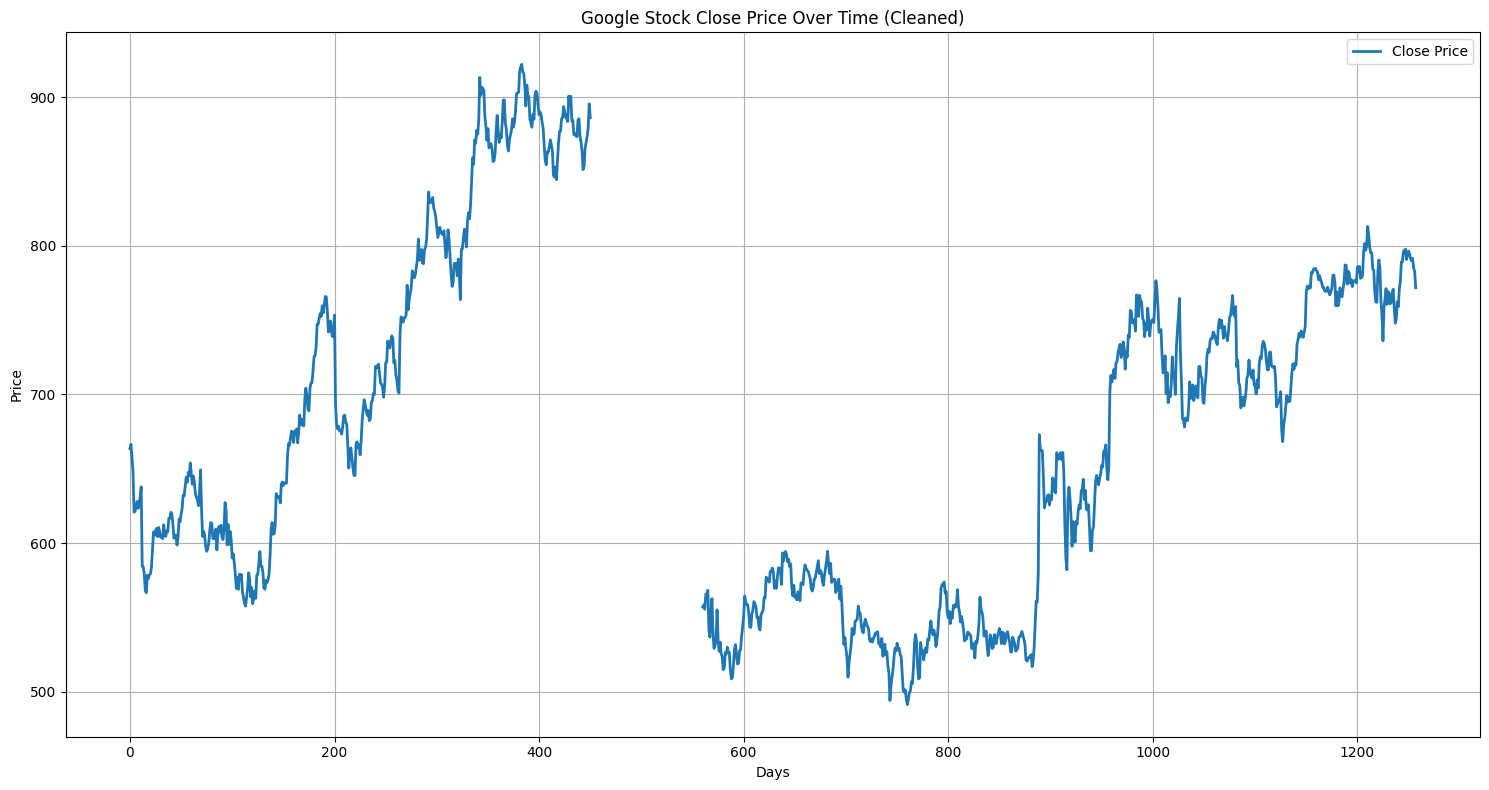

In [90]:
# Plot the cleaned data (Price over the days)
plt.figure(figsize=(15, 8))
plt.plot(train_data['Close'], label='Close Price', linewidth=2)
plt.title('Google Stock Close Price Over Time')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-92-06e7bab11d96>:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = train_data['Close'].pct_change()


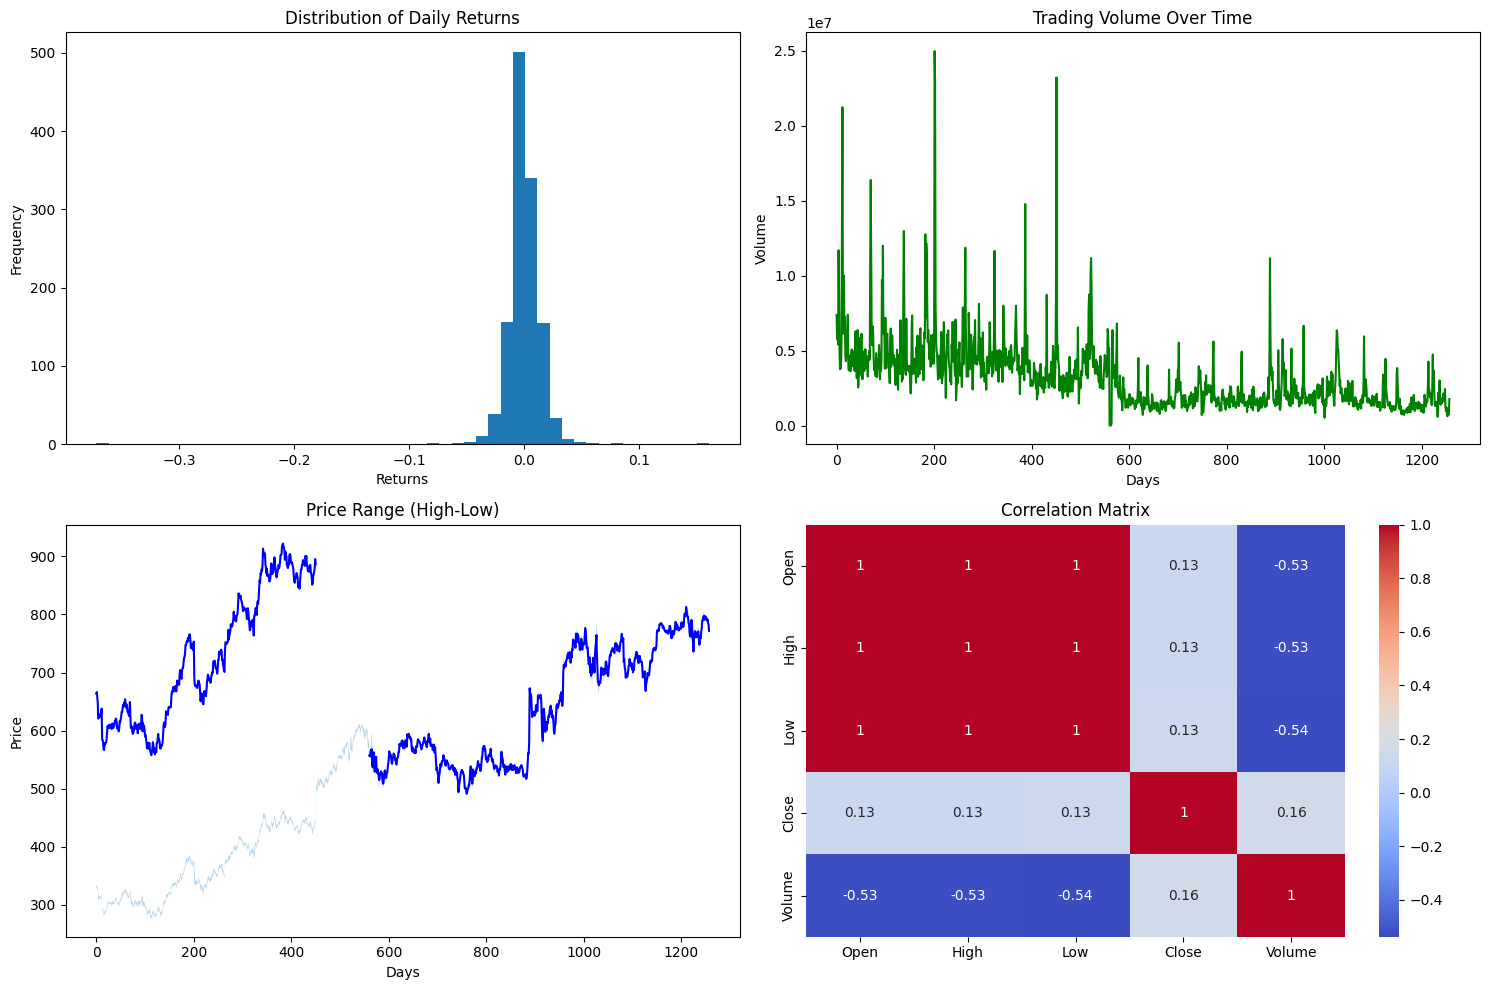

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily returns
daily_returns = train_data['Close'].pct_change()
axes[0, 0].hist(daily_returns.dropna(), bins=50)
axes[0, 0].set_title('Distribution of Daily Returns')
axes[0, 0].set_xlabel('Returns')
axes[0, 0].set_ylabel('Frequency')

# Volume over time
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(float)
axes[0, 1].plot(train_data['Volume'], color='green')
axes[0, 1].set_title('Trading Volume Over Time')
axes[0, 1].set_xlabel('Days')
axes[0, 1].set_ylabel('Volume')

# Price ranges (High-Low)
axes[1, 0].fill_between(range(len(train_data)),
                       train_data['High'],
                       train_data['Low'],
                       alpha=0.3)
axes[1, 0].plot(train_data['Close'], color='blue')
axes[1, 0].set_title('Price Range (High-Low)')
axes[1, 0].set_xlabel('Days')
axes[1, 0].set_ylabel('Price')

# Correlation heatmap
sns.heatmap(train_data[['Open', 'High', 'Low', 'Close', 'Volume']].corr(),
            annot=True,
            cmap='coolwarm',
            ax=axes[1, 1])
axes[1, 1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

In [93]:
# Print summary statistics
print("\nSummary statistics of cleaned data:")
print(train_data[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

train_data.to_csv('train_cleaned.csv', index=False)
test_data.to_csv('test_cleaned.csv', index=False)


Summary statistics of cleaned data:
              Open         High          Low        Close        Volume
count  1258.000000  1258.000000  1258.000000  1149.000000  1.258000e+03
mean    533.709833   537.880223   529.007409   674.775527  3.158107e+06
std     151.904442   153.008811   150.552807   112.582696  2.273726e+06
min     279.120000   281.210000   277.220000   491.200000  7.900000e+03
25%     404.115000   406.765000   401.765000   571.580000  1.621700e+06
50%     537.470000   540.750000   532.990000   673.690000  2.566150e+06
75%     654.922500   662.587500   644.800000   761.680000  4.122500e+06
max     816.680000   816.680000   805.140000   922.160000  2.497790e+07


In [96]:
# Load our cleaned data
train_data = pd.read_csv('/content/train_cleaned.csv')
test_data = pd.read_csv('/content/test_cleaned.csv')

features = ['Open', 'High', 'Low', 'Close', 'Volume']

numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
train_data[numeric_cols] = train_data[numeric_cols].fillna(train_data[numeric_cols].mean())
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(float) # This line is added to fix the error

# Scale everything between 0 and 1
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[features])
test_scaled = scaler.transform(test_data[features])


# Function to create our sequences
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 3])
    return np.array(X), np.array(y)

# Since our test set is tiny (only 20 entries), taking some data from train
last_train_chunk = train_scaled[-30:]
test_with_context = np.vstack((last_train_chunk, test_scaled))

# Create our training sequences
seq_length = 30
X, y = create_sequences(train_scaled, seq_length)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create test sequences using our combined data
X_test, y_test = create_sequences(test_with_context, seq_length)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Just to double check we have test data now
print("\nNumber of test predictions we can make:", len(y_test))

Training set shape: (982, 30, 5)
Validation set shape: (246, 30, 5)
Test set shape: (20, 30, 5)

Number of test predictions we can make: 20


## Model Training

In [101]:
def train_model(model_type, params, X_train, X_val, y_train, y_val):
    seq_length = X_train.shape[1]
    n_features = X_train.shape[2]

    # Create model
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(params['units'], return_sequences=True,
                      input_shape=(seq_length, n_features)))
        model.add(Dropout(params['dropout']))
        model.add(LSTM(params['units']//2))
    elif model_type == 'GRU':
        model.add(GRU(params['units'], return_sequences=True,
                     input_shape=(seq_length, n_features)))
        model.add(Dropout(params['dropout']))
        model.add(GRU(params['units']//2))
    else:
        model.add(SimpleRNN(params['units'], return_sequences=True,
                          input_shape=(seq_length, n_features)))
        model.add(Dropout(params['dropout']))
        model.add(SimpleRNN(params['units']//2))

    model.add(Dense(1))
    model.compile(optimizer=params['optimizer'], loss='mse', metrics=['mae'])

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    return model, history

def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{title} - MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, title, X_test, y_test, scaler):
    y_pred = model.predict(X_test)

    y_test_inv = scaler.inverse_transform(np.zeros((len(y_test), 5)))
    y_test_inv[:, 3] = y_test
    y_test_actual = y_test_inv[:, 3]

    y_pred_inv = scaler.inverse_transform(np.zeros((len(y_pred), 5)))
    y_pred_inv[:, 3] = y_pred.flatten()
    y_pred_actual = y_pred_inv[:, 3]

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label='Actual')
    plt.plot(y_pred_actual, label='Predicted')
    plt.title(f'{title} - Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def plot_model_comparisons(results, X_test, y_test, scaler):
    fig = plt.figure(figsize=(20, 12))

    plt.subplot(2, 2, 1)
    for model_type, result in results.items():
        plt.plot(result['history'].history['loss'], label=f'{model_type} Training')
        plt.plot(result['history'].history['val_loss'], label=f'{model_type} Validation')
    plt.title('Loss Comparison Across Models')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    for model_type, result in results.items():
        plt.plot(result['history'].history['mae'], label=f'{model_type} Training')
        plt.plot(result['history'].history['val_mae'], label=f'{model_type} Validation')
    plt.title('MAE Comparison Across Models')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.subplot(2, 1, 2)
    for model_type, result in results.items():
        predictions = result['model'].predict(X_test)
        inverse_predictions = scaler.inverse_transform(np.zeros((len(predictions), 5)))
        inverse_predictions[:, 3] = predictions.flatten()
        plt.plot(inverse_predictions[:, 3], label=f'{model_type} Predictions')

    actual_values = scaler.inverse_transform(np.zeros((len(y_test), 5)))
    actual_values[:, 3] = y_test
    plt.plot(actual_values[:, 3], label='Actual', linestyle='--', color='black', linewidth=2)

    plt.title('Model Predictions vs Actual Values')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()

    plt.tight_layout()
    plt.show()

def print_model_comparison_table(results, X_test, y_test):
    print("\n=== Model Performance Comparison ===")
    print("\n{:<15} {:<15} {:<15} {:<15} {:<15}".format(
        "Model Type", "Train Loss", "Val Loss", "Test Loss", "Test MAE"
    ))
    print("-" * 75)

    for model_type, result in results.items():
        final_train_loss = result['history'].history['loss'][-1]
        final_val_loss = result['history'].history['val_loss'][-1]


        test_loss, test_mae = result['model'].evaluate(X_test, y_test, verbose=0)

        print("{:<15} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}".format(
            model_type, final_train_loss, final_val_loss, test_loss, test_mae
        ))


In [ ]:
# Parameters
model_params = {
    'LSTM': [
        {'units': 50, 'dropout': 0.2, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 32},
        {'units': 100, 'dropout': 0.3, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 64}
    ],
    'GRU': [
        {'units': 50, 'dropout': 0.2, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 32},
        {'units': 100, 'dropout': 0.3, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 64}
    ],
    'SimpleRNN': [
        {'units': 50, 'dropout': 0.2, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 32},
        {'units': 100, 'dropout': 0.3, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 64}
    ]
}


## Training LSTM Model

Training LSTM models...

Parameters: {'units': 50, 'dropout': 0.2, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 32}
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0593 - mae: 0.1838 - val_loss: 0.0072 - val_mae: 0.0598
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mae: 0.0497 - val_loss: 0.0058 - val_mae: 0.0471
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0423 - val_loss: 0.0050 - val_mae: 0.0455
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0410 - val_loss: 0.0049 - val_mae: 0.0432
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0397 - val_loss: 0.0045 - val_mae: 0.0426
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mae: 0.0358 - val_loss: 0.0042 - val_mae: 0.0428
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0385 - val_loss: 0.0041 - val_mae: 0.0394
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 

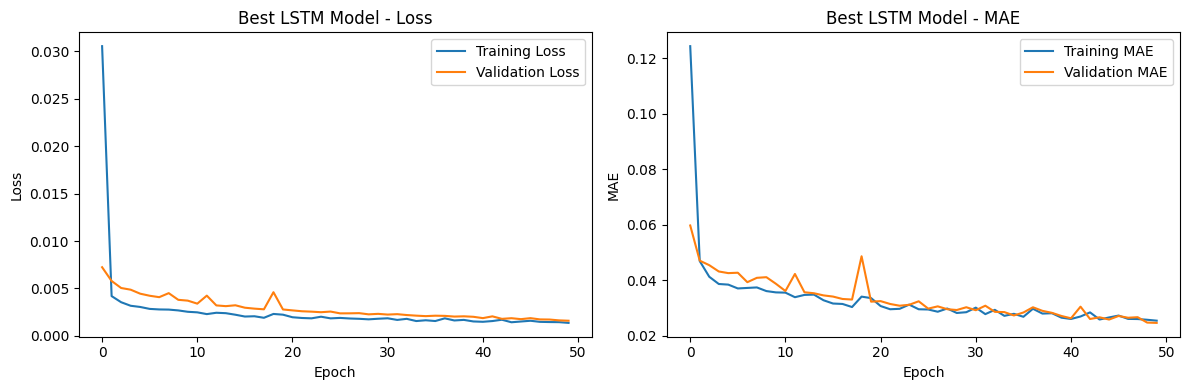

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


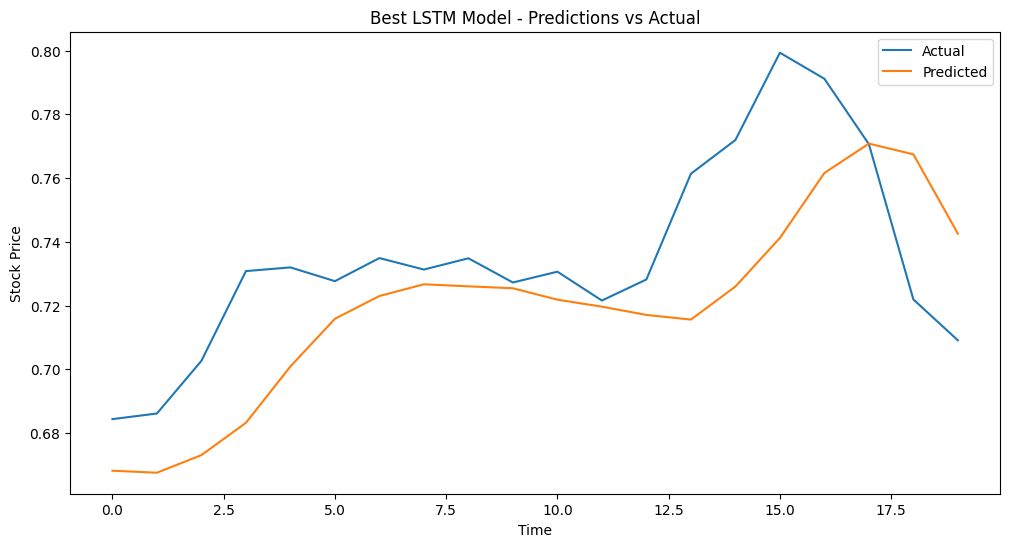

In [102]:
lstm_results = {}
best_val_loss = float('inf')

print("Training LSTM models...")
for params in model_params['LSTM']:
    print(f"\nParameters: {params}")
    model, history = train_model('LSTM', params, X_train, X_val, y_train, y_val)
    val_loss = min(history.history['val_loss'])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        lstm_results = {
            'model': model,
            'history': history,
            'params': params,
            'val_loss': val_loss
        }

# Plot results
plot_history(lstm_results['history'], 'Best LSTM Model')
plot_predictions(lstm_results['model'], 'Best LSTM Model', X_test, y_test, scaler)


## Training GRU Model

Training GRU models...

Parameters: {'units': 50, 'dropout': 0.2, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 32}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0398 - mae: 0.1563 - val_loss: 0.0049 - val_mae: 0.0495
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0477 - val_loss: 0.0025 - val_mae: 0.0296
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0393 - val_loss: 0.0023 - val_mae: 0.0290
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0365 - val_loss: 0.0025 - val_mae: 0.0313
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mae: 0.0357 - val_loss: 0.0021 - val_mae: 0.0286
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mae: 0.0339 - val_loss: 0.0023 - val_mae: 0.0319
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mae: 0.0320 - val_loss: 0.0020 - val_mae: 0.0280
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019 - mae: 0.0320 - val_loss: 0.0021 - val_mae: 0.0294
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - mae: 0.0325 -

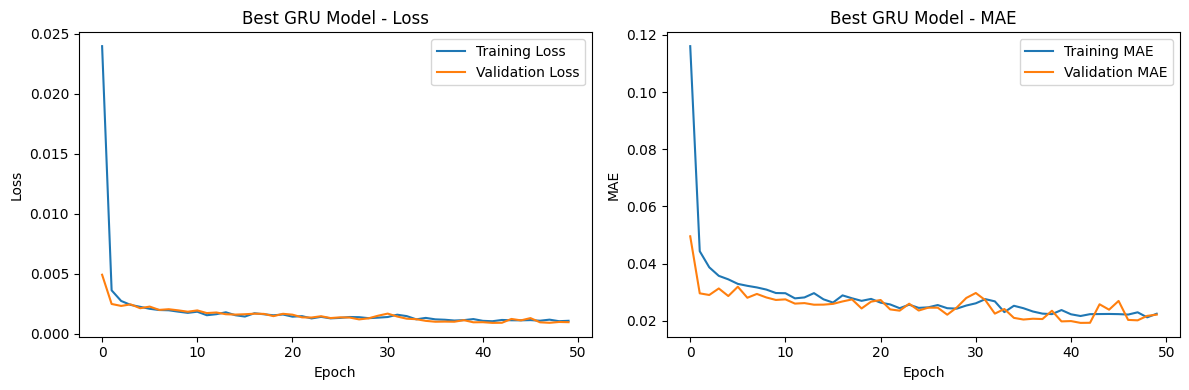

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


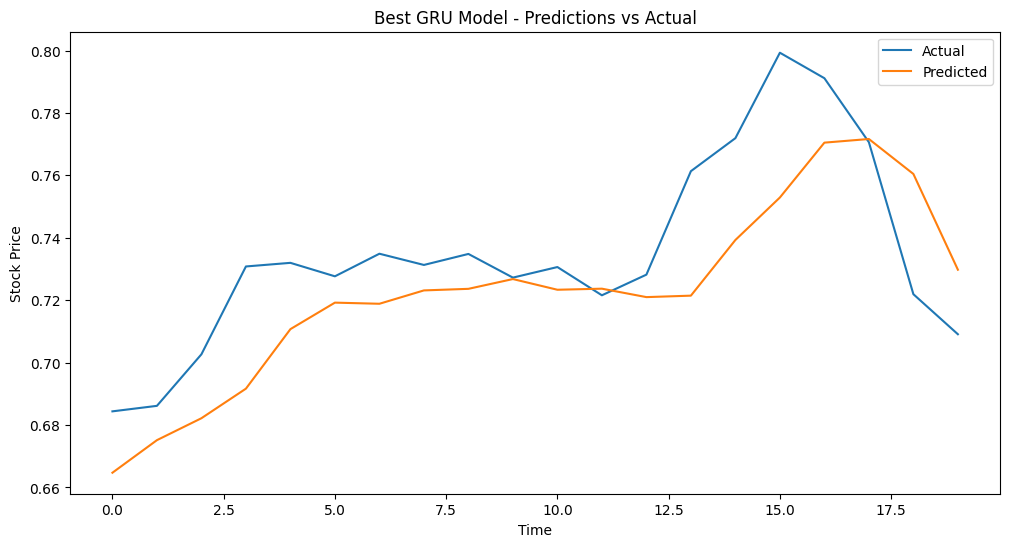

In [103]:
gru_results = {}
best_val_loss = float('inf')

print("Training GRU models...")
for params in model_params['GRU']:
    print(f"\nParameters: {params}")
    model, history = train_model('GRU', params, X_train, X_val, y_train, y_val)
    val_loss = min(history.history['val_loss'])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        gru_results = {
            'model': model,
            'history': history,
            'params': params,
            'val_loss': val_loss
        }

# Plot results
plot_history(gru_results['history'], 'Best GRU Model')
plot_predictions(gru_results['model'], 'Best GRU Model', X_test, y_test, scaler)


## Training SimpleRNN Model

Training SimpleRNN models...

Parameters: {'units': 50, 'dropout': 0.2, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 32}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - loss: 0.6742 - mae: 0.6144 - val_loss: 0.0355 - val_mae: 0.1546
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0443 - mae: 0.1670 - val_loss: 0.0071 - val_mae: 0.0627
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0191 - mae: 0.1099 - val_loss: 0.0088 - val_mae: 0.0726
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0134 - mae: 0.0910 - val_loss: 0.0054 - val_mae: 0.0517
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0125 - mae: 0.0885 - val_loss: 0.0054 - val_mae: 0.0526
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - mae: 0.0793 - val_loss: 0.0048 - val_mae: 0.0497
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - mae: 0.0755 - val_loss: 0.0048 - val_mae: 0.0509
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mae: 0.0705 - val_loss: 0.0062 - val_mae: 0.0590
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mae: 0.0607

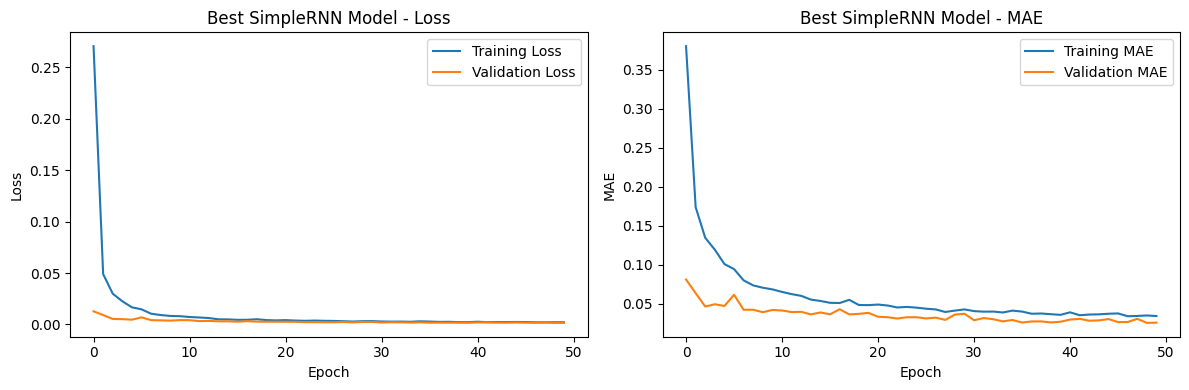

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


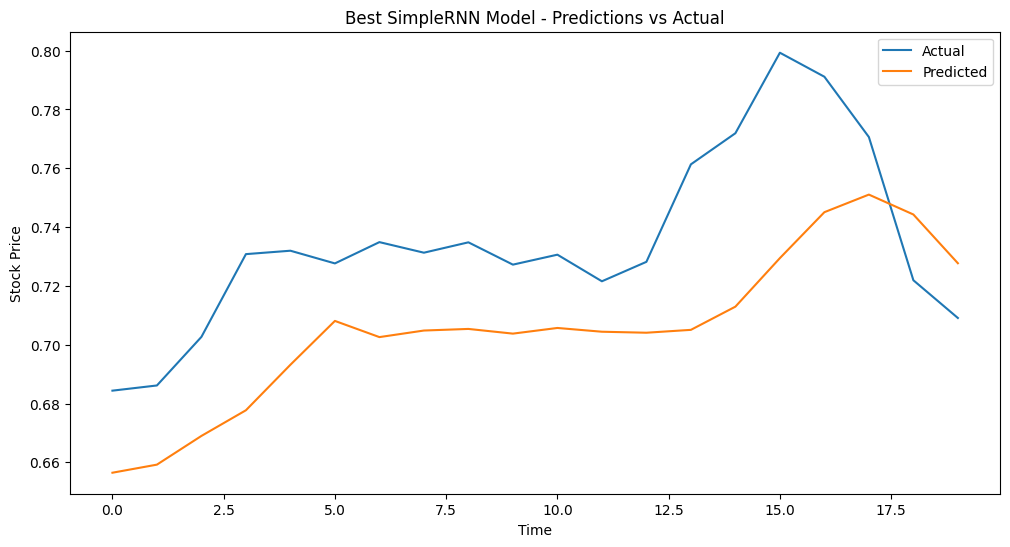

In [104]:
rnn_results = {}
best_val_loss = float('inf')

print("Training SimpleRNN models...")
for params in model_params['SimpleRNN']:
    print(f"\nParameters: {params}")
    model, history = train_model('SimpleRNN', params, X_train, X_val, y_train, y_val)
    val_loss = min(history.history['val_loss'])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        rnn_results = {
            'model': model,
            'history': history,
            'params': params,
            'val_loss': val_loss
        }

# Plot results
plot_history(rnn_results['history'], 'Best SimpleRNN Model')
plot_predictions(rnn_results['model'], 'Best SimpleRNN Model', X_test, y_test, scaler)


# Comparative Analysis of Models

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


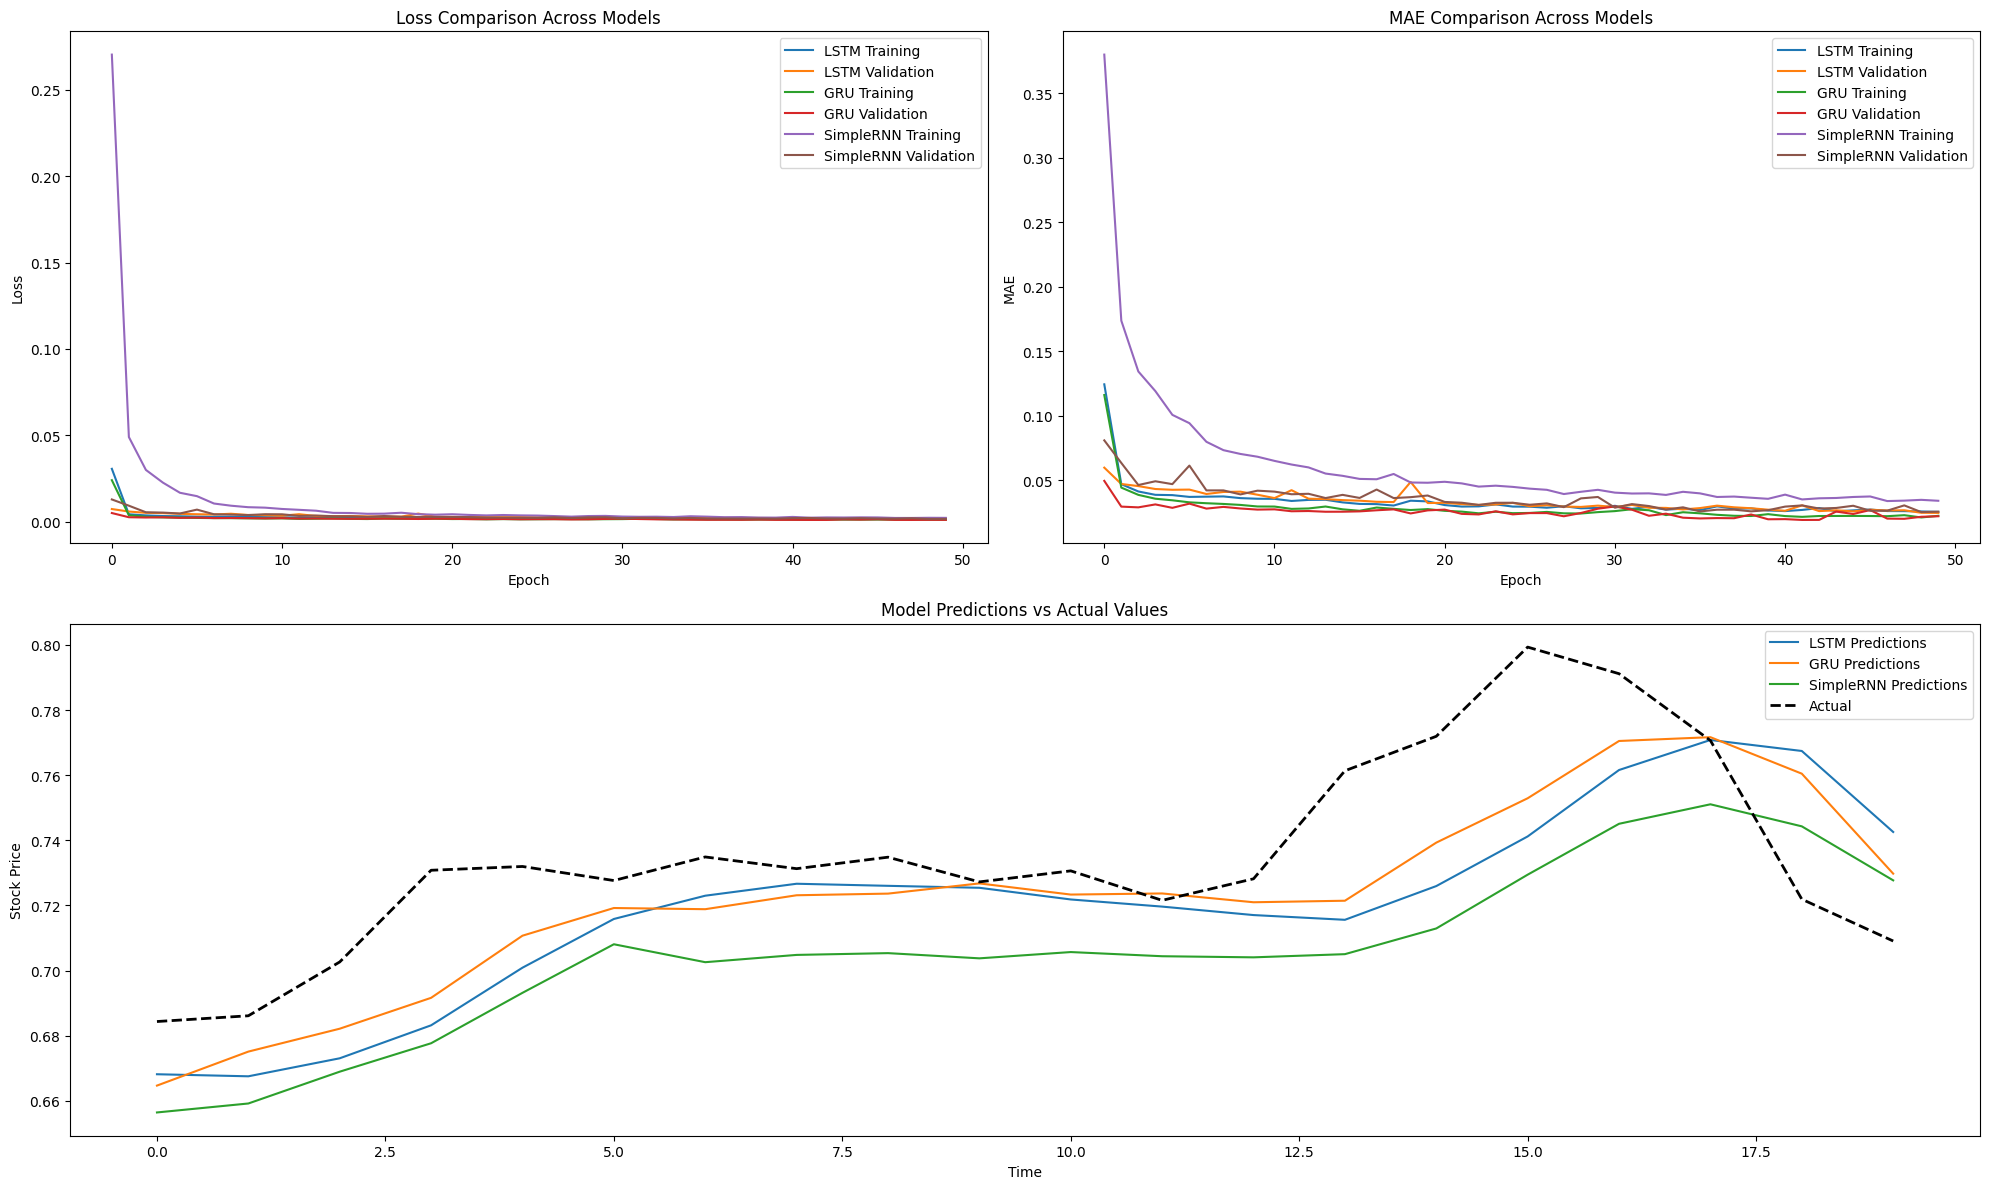


=== Model Performance Comparison ===

Model Type      Train Loss      Val Loss        Test Loss       Test MAE       
---------------------------------------------------------------------------
LSTM            0.001373        0.001600        0.000847        0.023114       
GRU             0.001093        0.000977        0.000535        0.018612       
SimpleRNN       0.002127        0.001548        0.001344        0.033479       


In [106]:
results = {
    'LSTM': lstm_results,
    'GRU': gru_results,
    'SimpleRNN': rnn_results
}


plot_model_comparisons(results, X_test, y_test, scaler)
print_model_comparison_table(results, X_test, y_test)

In [107]:
# Additional Metrics
print("\n=== Additional Analysis ===")
for model_type, result in results.items():
    predictions = result['model'].predict(X_test)

    errors = y_test - predictions.flatten()
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    mape = np.mean(np.abs(errors / y_test)) * 100

    print(f"\n{model_type} Error Metrics:")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAPE: {mape:.2f}%")


=== Additional Analysis ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

LSTM Error Metrics:
MAE: 0.023114
RMSE: 0.029109
MAPE: 3.12%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

GRU Error Metrics:
MAE: 0.018612
RMSE: 0.023120
MAPE: 2.51%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

SimpleRNN Error Metrics:
MAE: 0.033479
RMSE: 0.036662
MAPE: 4.51%


In [68]:
final_predictions = {}
for model_type, result in results.items():
    predictions = result['model'].predict(X_test)
    inverse_predictions = scaler.inverse_transform(np.zeros((len(predictions), 5)))
    inverse_predictions[:, 3] = predictions.flatten()
    final_predictions[model_type] = inverse_predictions[:, 3]

actual_values = scaler.inverse_transform(np.zeros((len(y_test), 5)))
actual_values[:, 3] = y_test

prediction_df = pd.DataFrame({
    'Actual': actual_values[:, 3]
})
for model_type in final_predictions:
    prediction_df[f'{model_type}_Prediction'] = final_predictions[model_type]

prediction_df.to_csv('model_predictions.csv', index=False)
print("\nPredictions saved to 'model_predictions.csv'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Predictions saved to 'model_predictions.csv'
